# Video stream train

In [51]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime

import tensorflow as tf

# Keras module and tools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout
from keras.layers import RandomFlip, CenterCrop, RandomZoom
from keras.metrics import sparse_categorical_accuracy, sparse_top_k_categorical_accuracy
from keras.losses import sparse_categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras_cv.layers import RandomCutout
import keras_tuner

In [52]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [53]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6} # to match the audio stream labels
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}

path_frames = "Datasets/RAVDESS_frames/"
path_frames_black = "Datasets/RAVDESS_frames_black/"

height_orig = 224
width_orig = 224
width_orig_full = 398
height_targ = 112
width_targ = 112

batch_size = 64
num_classes = len(emotions)

val_actors = ['19', '20']
test_actors = ['21', '22', '23', '24']

## Model 1: 224x224 color

### Dataset creation

In [54]:
filenames_train = []                                                            # train
filenames_val = []                                                              # validation

for (dirpath, dirnames, fn) in os.walk(path_frames):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [55]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize(image, [height_orig, width_orig_full])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [56]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (224, 398, 3)
frames number: 23184 
batch size: 64 
batch number: 362


In [57]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (224, 398, 3)
frames number: 2688 
batch size: 64 
batch number: 42


#### Augmentation

In [68]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    CenterCrop(height_orig, width_orig),
    RandomZoom(height_factor=(-0.2, 0.2))
    ])

#### Examples

(224, 398, 3)


(-0.5, 397.5, 223.5, -0.5)

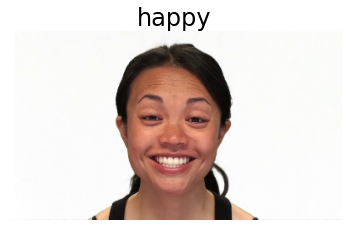

In [69]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)

o = elem[0]
plt.imshow(o)
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
# plt.savefig('Plots/model1_input.png')

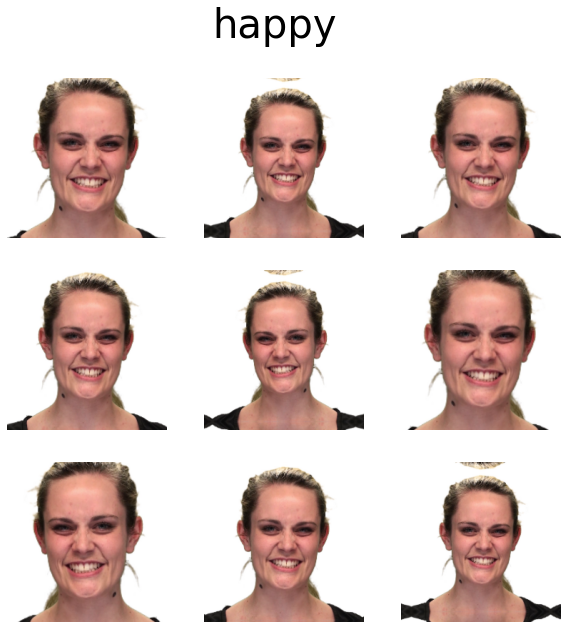

In [74]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
# plt.savefig('Plots/model1_augmentation.png')

### Net Architecture

In [61]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [62]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [63]:
pretrained_model = ResNet50(include_top=False,
                            input_shape=(height_orig, width_orig, 3),
                            weights='imagenet',
                            pooling='avg')
pretrained_model.trainable = False


input = Input(shape=(height_orig, width_orig_full, 3))
x = input
x = data_augmentation(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = pretrained_model(x, training=False) # `training=False` important for fine-tuning
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
output = x

net_1 = Model(input, output)
net_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 398, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 512)               1049

In [64]:
net_1.compile(
    optimizer=Adam(learning_rate=lr),
    # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
    loss=sparse_categorical_crossentropy,
    metrics=[sparse_categorical_accuracy, sparse_top_k_categorical_accuracy],
)

### Training

In [ ]:
history_1 = net_1.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

### Evaluation

In [ ]:
net_1.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

42/42 [==============================] - 15s 306ms/step - loss: 2.4520 - sparse_categorical_accuracy: 0.2429 - sparse_top_k_categorical_accuracy: 0.7496


[2.452014207839966, 0.2429315447807312, 0.749627947807312]

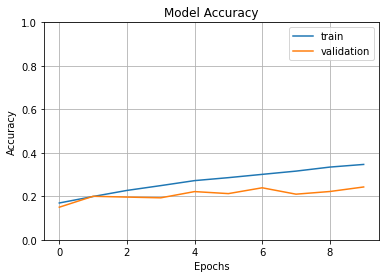

In [ ]:
fig1 = plt.gcf()
plt.plot(history_1.history['sparse_categorical_accuracy'])
plt.plot(history_1.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model1_accuracy.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_1(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.13      0.14       384
           1       0.30      0.90      0.45       384
           2       0.00      0.00      0.00       384
           3       0.00      0.00      0.00       384
           4       0.20      0.48      0.28       384
           5       0.30      0.17      0.22       384
           6       0.19      0.01      0.02       384

    accuracy                           0.24      2688
   macro avg       0.16      0.24      0.16      2688
weighted avg       0.16      0.24      0.16      2688



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2: 224x224 black background

### Dataset creation

In [75]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames_black):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [76]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize(image, [height_orig, width_orig])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [77]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (224, 224, 3)
frames number: 23184 
batch size: 64 
batch number: 362


In [78]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (224, 224, 3)
frames number: 2688 
batch size: 64 
batch number: 42


#### Augmentation

In [79]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomZoom(height_factor=(-0.2, 0.2))
])

#### Examples

(224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

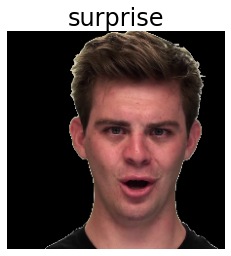

In [80]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0])
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
# plt.savefig('Plots/model1_input.png')

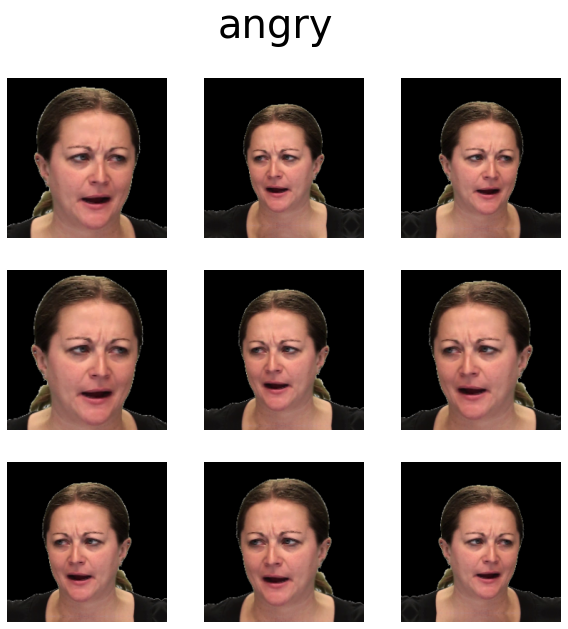

In [84]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
# plt.savefig('Plots/model2_augmentation.png')

### Net Architecture

In [28]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [29]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [30]:
pretrained_model = ResNet50(include_top=False,
                            input_shape=(height_orig, width_orig, 3),
                            weights='imagenet',
                            pooling='avg')
pretrained_model.trainable = False


input = Input(shape=(height_orig, width_orig, 3))
x = input
x = data_augmentation(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = pretrained_model(x, training=False) # `training=False` important for fine-tuning
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
output = x

net_2 = Model(input, output)
net_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 512)               1049

In [31]:
net_2.compile(
    optimizer=Adam(learning_rate=lr),
    # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
    loss=sparse_categorical_crossentropy,
    metrics=[sparse_categorical_accuracy, sparse_top_k_categorical_accuracy],
)

### Training

In [32]:
history_2 = net_2.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

Epoch 1/10
362/362 [==============================] - 147s 398ms/step - loss: 1.9742 - sparse_categorical_accuracy: 0.1549 - sparse_top_k_categorical_accuracy: 0.7390 - val_loss: 1.9695 - val_sparse_categorical_accuracy: 0.1429 - val_sparse_top_k_categorical_accuracy: 0.7645
Epoch 2/10
362/362 [==============================] - 147s 408ms/step - loss: 1.9272 - sparse_categorical_accuracy: 0.1776 - sparse_top_k_categorical_accuracy: 0.7749 - val_loss: 1.9361 - val_sparse_categorical_accuracy: 0.2028 - val_sparse_top_k_categorical_accuracy: 0.7243
Epoch 3/10
362/362 [==============================] - 147s 405ms/step - loss: 1.8919 - sparse_categorical_accuracy: 0.2095 - sparse_top_k_categorical_accuracy: 0.8080 - val_loss: 1.9136 - val_sparse_categorical_accuracy: 0.2262 - val_sparse_top_k_categorical_accuracy: 0.7295
Epoch 4/10
362/362 [==============================] - 146s 404ms/step - loss: 1.8625 - sparse_categorical_accuracy: 0.2263 - sparse_top_k_categorical_accuracy: 0.8318 - val

### Evaluation

In [33]:
net_2.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

42/42 [==============================] - 14s 312ms/step - loss: 1.9076 - sparse_categorical_accuracy: 0.2273 - sparse_top_k_categorical_accuracy: 0.8482


[1.9076265096664429, 0.2273065447807312, 0.8482142686843872]

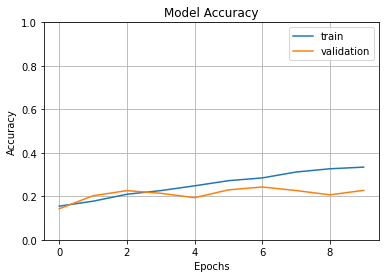

In [40]:
fig1 = plt.gcf()
plt.plot(history_2.history['sparse_categorical_accuracy'])
plt.plot(history_2.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model2_accuracy.png')
plt.show()

In [36]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_2(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.90      0.28       384
           1       0.43      0.65      0.52       384
           2       0.44      0.04      0.07       384
           3       0.00      0.00      0.00       384
           4       0.00      0.00      0.00       384
           5       0.00      0.00      0.00       384
           6       0.00      0.00      0.00       384

    accuracy                           0.23      2688
   macro avg       0.15      0.23      0.12      2688
weighted avg       0.15      0.23      0.12      2688



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 3: 112x112 BW

### Dataset creation

In [ ]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [ ]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [ ]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 23184 
batch size: 64 
batch number: 362


In [ ]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 2688 
batch size: 64 
batch number: 42


#### Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    # RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None)
])

#### Examples

(112, 112, 1)


(-0.5, 111.5, 111.5, -0.5)

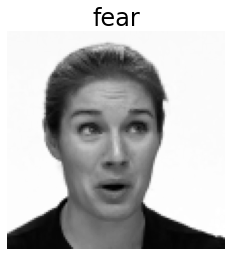

In [ ]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
# plt.savefig('Plots/model3_input.png')

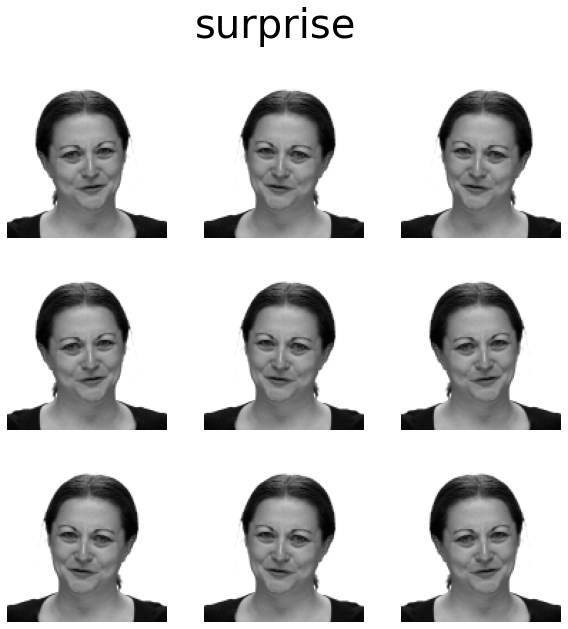

In [ ]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
# plt.savefig('Plots/model3_augmentation.png')

### Net Architecture

In [ ]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [ ]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [ ]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.4, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.4, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

net_3 = Model(inputs=input, outputs=output)
net_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 112, 112, 1)       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                             

In [ ]:
net_3.compile(
        optimizer = Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

### Training

In [ ]:
history_3 = net_3.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

Epoch 1/10
362/362 [==============================] - 57s 123ms/step - loss: 2.0008 - sparse_categorical_accuracy: 0.3110 - val_loss: 2.0325 - val_sparse_categorical_accuracy: 0.3028
Epoch 2/10
362/362 [==============================] - 46s 127ms/step - loss: 1.3030 - sparse_categorical_accuracy: 0.5125 - val_loss: 2.2805 - val_sparse_categorical_accuracy: 0.3478
Epoch 3/10
362/362 [==============================] - 55s 153ms/step - loss: 1.0268 - sparse_categorical_accuracy: 0.6224 - val_loss: 2.8971 - val_sparse_categorical_accuracy: 0.2530
Epoch 4/10
362/362 [==============================] - 54s 148ms/step - loss: 0.8332 - sparse_categorical_accuracy: 0.6986 - val_loss: 2.4932 - val_sparse_categorical_accuracy: 0.3359
Epoch 5/10
362/362 [==============================] - 59s 164ms/step - loss: 0.7031 - sparse_categorical_accuracy: 0.7511 - val_loss: 2.5712 - val_sparse_categorical_accuracy: 0.4044
Epoch 6/10
362/362 [==============================] - 57s 158ms/step - loss: 0.6072 -

### Evaluation

In [ ]:
net_3.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

42/42 [==============================] - 3s 49ms/step - loss: 2.4979 - sparse_categorical_accuracy: 0.4081


[2.4978621006011963, 0.408110111951828]

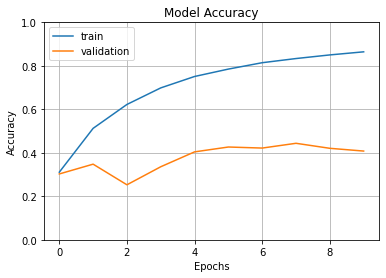

In [ ]:
fig1 = plt.gcf()
plt.plot(history_3.history['sparse_categorical_accuracy'])
plt.plot(history_3.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model3_accuracy.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_3(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.30      0.39       384
           1       0.67      0.38      0.48       384
           2       0.29      0.58      0.39       384
           3       0.29      0.49      0.36       384
           4       0.53      0.64      0.58       384
           5       0.48      0.42      0.45       384
           6       0.43      0.04      0.07       384

    accuracy                           0.41      2688
   macro avg       0.46      0.41      0.39      2688
weighted avg       0.46      0.41      0.39      2688

